## Projeto Classificado de vinhos tintos
integrantes: Raphael Jacob Butori, Roberto Scnhorrenberg - Turma B

In [171]:
import pandas as pd
import numpy as np
import math
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets, ensemble
from sklearn.metrics import mean_squared_error
import seaborn as sns

# Objetivo:

A partir de um dataset com as principais características de vinhos tintos e suas respectivas classificações na base de dados, o objetivo de nosso projeto é automatizar este processo de classificação para que possam ser colocados novos vinhos na base sem necessidade de classificação manual, e com critérios similares aos utilizados na base originária.

##### Leitura e limpeza dos dados
Observamos a necessidade de retirar linhas repetidas no dataset, visto que não é de nosso interesse que certo tipo ou certo vinho específico tenha peso maior que outro, para nossa predição, para isso elaboramos um código de exclusão de linhas que se repetem por inteiro, levando em conta que tal repetição pode (e ocorria) ocorrer mais de uma vez seguida:

In [ ]:
dados1=pd.read_csv('wine_quality.csv')

In [ ]:
def limpeza(x):
    for y in range(len(x)-1):
        i=0
        seguidos=0
        for z in x.columns:
            if x[z][y+1]==x[z][y-seguidos]:
                i+=1
        if i==len(x.columns):
            x.drop(index=y,inplace=True)
            seguidos+=1
        else:
            seguidos=0

In [ ]:
limpeza(dados1)

In [ ]:
dados1.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


##### Separação Treinamento/ Teste
Como estamos lidando com apenas um dataset, e o mesmo deve ser utilizado tanto para treinamento quanto teste da classificação de qualidade do vinho, é necessário dividirmos o dataset, a proporção utilizada foi 75% / 25%, respectivamente

In [ ]:
dados=dados1[0:round((len(dados1))*.75)]
dadost=dados1[round((len(dados1))*.75):]

### Análise exploratória dos dados

Como fizemos a limpeza das linhas repetidas, é importante analisarmos novamente o tamanho de nosso dataset e avaliar se este satisfaz nossas necessidades, com o comando describe conseguimos extrair tanto esta informação quanto algumas outras sobre o conteúdo de nossos dados, o que pode nos dar uma ideia de alguns problemas os quais enfrentaremos gerados pela base origem.

In [ ]:
dados.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1131.000000,1131.000000,1131.000000,1131.000000,1131.000000,1131.000000,1131.000000,1131.000000,1131.000000,1131.000000,1131.000000,1131.000000
mean,8.612909,0.520234,0.292414,2.558709,0.089513,15.341291,47.309461,0.997052,3.298267,0.667542,10.379399,5.656941
std,1.764044,0.179039,0.195915,1.245838,0.049275,10.256458,34.274990,0.001862,0.155447,0.178764,1.094455,0.812999
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.300000,0.390000,0.120000,1.900000,0.071000,7.000000,22.000000,0.996000,3.200000,0.560000,9.500000,5.000000
50%,8.300000,0.500000,0.280000,2.200000,0.080000,13.000000,38.000000,0.997000,3.300000,0.620000,10.000000,6.000000
75%,9.600000,0.630000,0.450000,2.700000,0.092000,21.000000,63.000000,0.998150,3.390000,0.740000,11.000000,6.000000
max,15.900000,1.330000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003200,3.900000,2.000000,14.900000,8.000000


In [ ]:
np.sum(dados.isnull())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### Histogramas

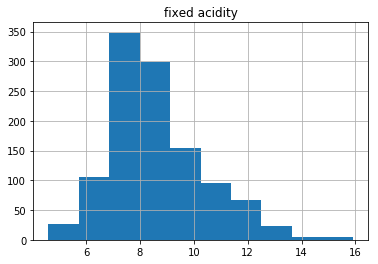

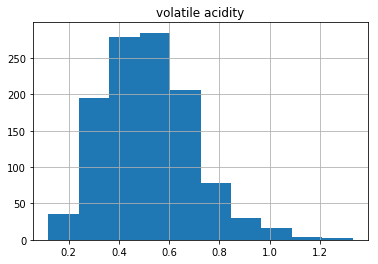

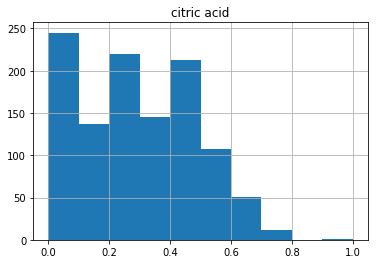

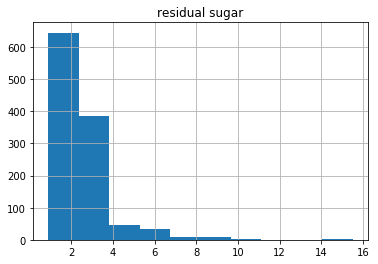

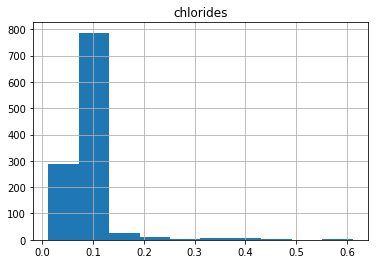

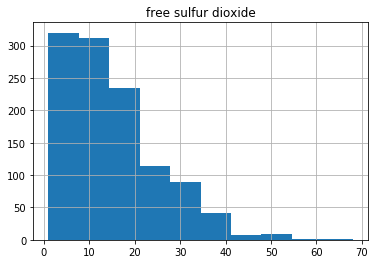

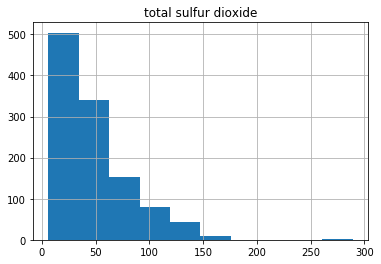

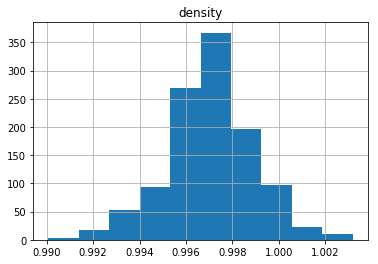

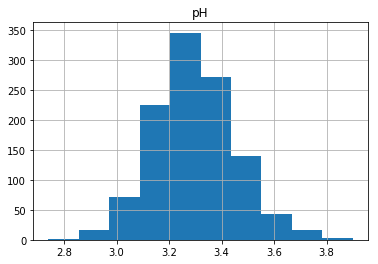

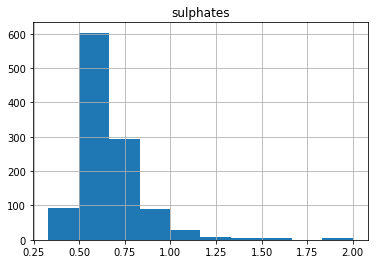

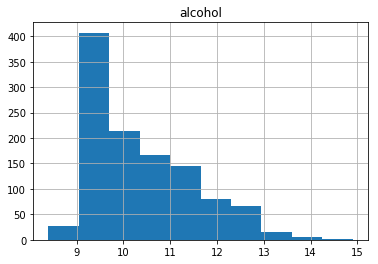

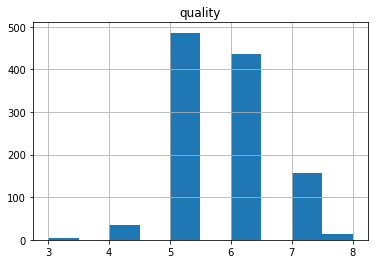

In [ ]:
for x in dados.columns:
    dados.hist(column=x)

##### Análise dos histogramas
Os histogramas plotados tem como objetivo nos indicar a existência de concentrações de valores, com a análise deles podemos observar campos onde a atuação de nosso classificador pode ser mais ou menos relevante. Um resultado importantíssimo plotado neste boxplot é o referente a nossa variável de interesse, quality, no histograma referente a quality temos uma discrepância enorme na distribuição, tendo sua maioria concentrada por volta da nota 5, isso acarretará em uma forte tendência do classificador em estabelecer sua base por volta dessa mesma classificação, visto que isso reduz o erro total, como consquência de uma base tão concentrada também teremos a falta de predições nas notas conforme distam dessa mediana, dificultando a predição destes valores.

### Boxplot

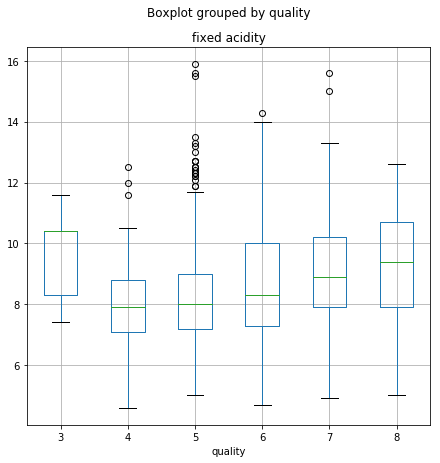

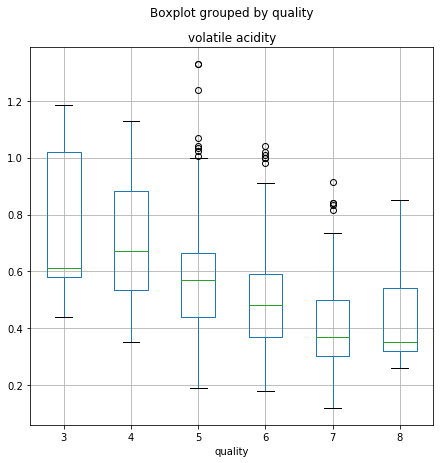

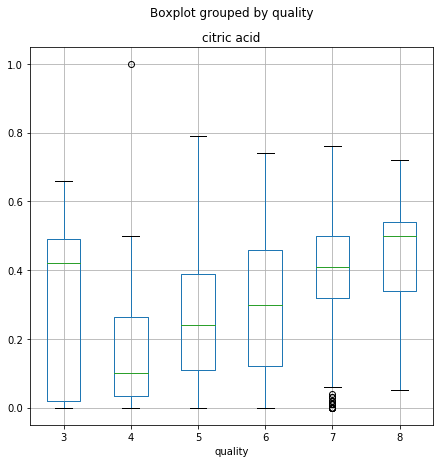

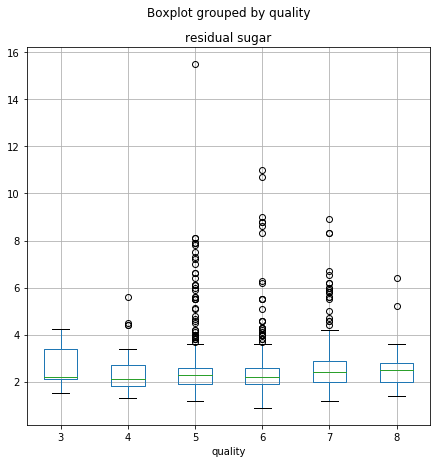

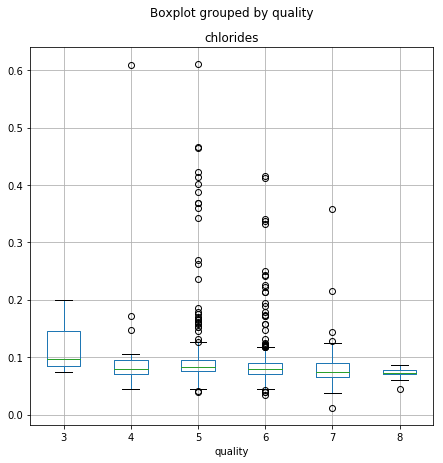

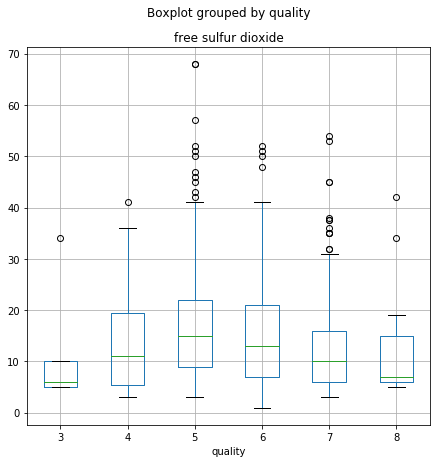

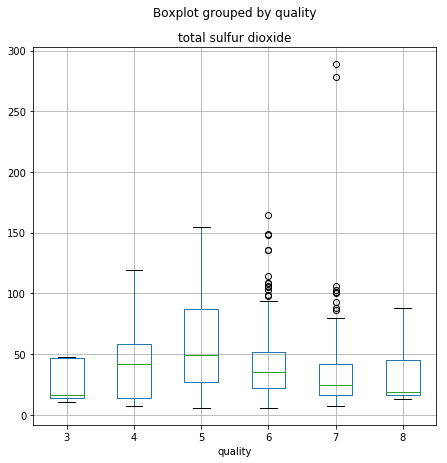

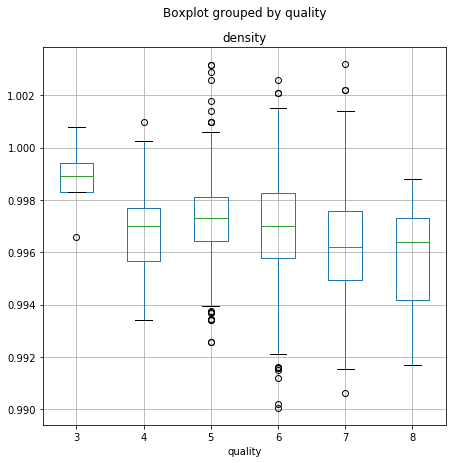

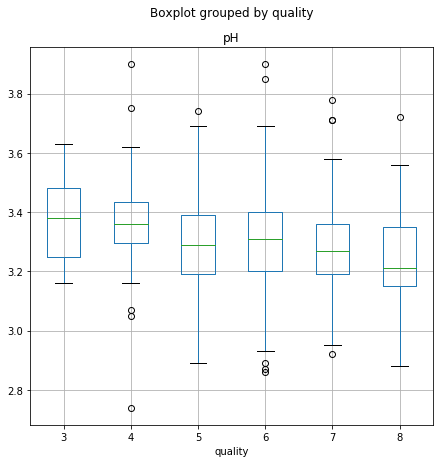

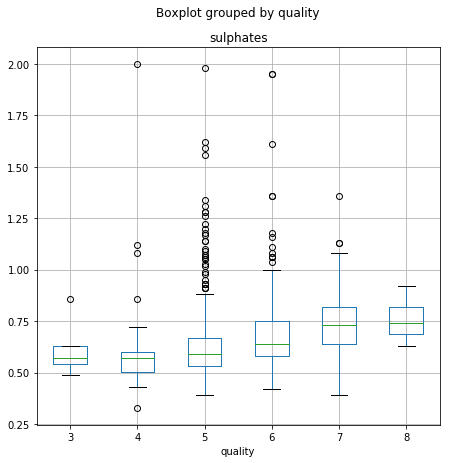

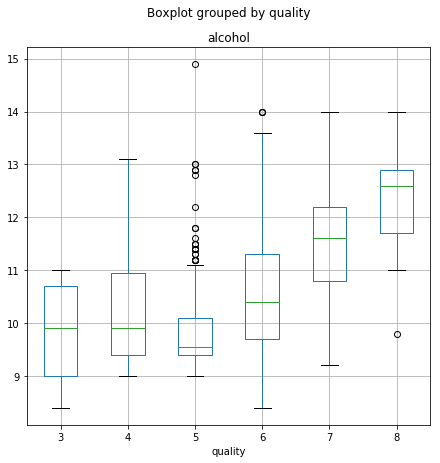

In [ ]:
for x in dados.columns:
    if x!='quality':
        dados.boxplot(column=x,by='quality',figsize=(7,7))

###### observação dos boxplots
Observando bem os boxplots podemos perceber algumas características decorrentes dos vinhos com uma avaliação melhor que o normal, como por exemplo, no Boxplot da "quality" em relação com a "fixed acidity" é possível discernir que um vinho tinto bom com alta avaliação possui um grau um pouco maior de acidez em sua constituição, quando sua linha verde representando a mediana está presente acima das demais.

Onde podemos aobservar com mais clareza no Boxplot da relação da "quality" com o "alcohol", nesse quadrante fica explicito que um vinho mais bem avaliado possui um nível alcoolico mais elevado. E portanto, além desse Boxplot outros como os das variáveis "sulphates"e "citric acids" tamém possuem a mesma relação, ou seja, quanto mais "sulphates" e "citric acids" melhor será a nota do vinho em questão.

Por outro lado apresenta-se o inverso desse caso descrito acima. Ou seja, para algumas variáveis como "volatile acidity", "chlorides", "density" e "pH" se tem um processo contrário, onde quanto menor a quantidade dessas variáveis estiverem presentes no vinho em questão melhor será sua nota.

### Observação das correlações entre as variáveis
Um critério necessário para escolha de quais variáveis tratar em uma regressão é a existência de uma correlação altíssima entre duas variáveis quaisquer, em tal caso é necessária a remoção de uma delas, ainda que seu 'valor p' não seja tão alto, para a visualização de tais correlações optamos pela plotagem de um heatmap.

In [ ]:
teste=dados.corr()

In [ ]:
n = teste.shape[0]
teste.iloc[range(n),range(n)]= float('NaN')

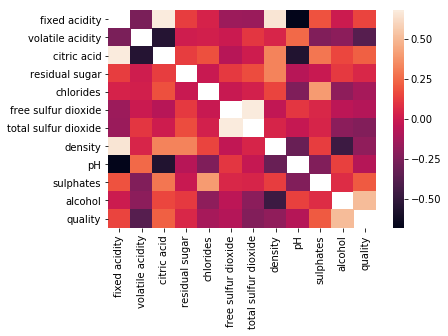

In [ ]:
heatmap(teste);

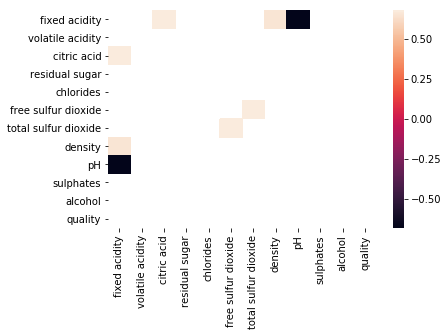

In [ ]:
teste1=teste[(teste.abs()>0.6)&(teste<1)]
heatmap(teste1);

### Limpeza de variáveis desnecessárias
Uma correlação muito alta e um "valor p" também alto acabam por desgastar o bom resultado da regressão realizada, portanto, é benéfica a remoção das variáveis que apresentem essas características.

Diante disso, elaboramos um código para a retirada de qualquer valor p que ultrapassasse o limite de 0.1 no valor p amplamente utilizado.

Vale ressaltar que o código consiste em um loop que efetua a retirada da variável com valor p mais alto uma vez por loop, até que nenhuma ultrapasse o limite estabelecido, uma vez que toda a vez que uma variável é retirada os dados mudam.

In [ ]:
def regressao(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

In [ ]:
def limpavar(df,varint):
    l=[]
    for x in df.columns:
        if x!=varint:
            l.append(x)
    maiorf=1
    while maiorf>0.1:
        results=regressao(df[l],df[varint])
        i=0
        imaior=0
        maior=0
        while i < len(results.pvalues):
            if results.pvalues[i]>maior:
                maior=results.pvalues[i]
                imaior=i
            i+=1
        maiorf=maior
        if maior>0.1:
            l.pop(imaior-1)
    results.summary()
    return l

In [ ]:
l1=limpavar(dados,'quality')

In [ ]:
results=regressao(dados[l1],dados['quality'])

#### Retirada das colunas
Como output da função descrita anteriormente obtivemos uma lista de colunas a serem descartadas, o código a seguir efetua o descarte das mesmas.

In [ ]:
def dropcol(x,l):
    for y in x.columns:
        if y not in l and y!='quality':
            x.drop(columns=[y],inplace=True)

In [ ]:
dropcol(dadost,l1)

C:\Users\rbuto\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Regressão Linear Múltipla
A análise da regressão tem por objetivo desvendar o comportamento entre uma variável dependente e as independentes. Modelos matemáticos são capazes de explicar essa relação por meio de uma equção que correlaciona a variável dependente com as independentes. É valido resaltar que a análise da regressão não garante que as variáveis explicativas sejam a causa da variável independente.

Nese caso, pode-se utilizar uma regressão linear multipla, buscando explicar a ocorrência da variável dependente em questão. 

Regressão múltipla é uma coleção de técnicas estatísticas para construir modelos que descrevem de maneira razoável relações entre várias variáveis explicativas de um determinado processo. A diferença entre a regressão linear simples e a múltipla é que na múltipla são tratadas duas ou mais variáveis explicativas.

Essencialmente consiste na atribuição de um coeficiente que multiplicará o valor para determinada coluna para posteriormente ser adicionado ao total, o valor inicial é uma constante, como citado anteriormente, e a partir dele são feitas mudanças com base nos dados de cada coluna.

In [ ]:
#predict#random-forest
def qtest(df):
    df.reset_index(inplace=True)
    if 'index' in df.columns:
        df.drop(columns=['index'])
    df['qualiteste_rlm']=results.params['const']+results.params['volatile acidity']*df['volatile acidity']\
                    +results.params['chlorides']*df['chlorides']\
                    +results.params['total sulfur dioxide']*df['total sulfur dioxide']\
                    +results.params['pH']*df['pH']\
                    +results.params['sulphates']*df['sulphates']\
                    +results.params['alcohol']*df['alcohol']


In [ ]:
qtest(dadost)

C:\Users\rbuto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


#### Round
Nossa variável de interesse trata-se de uma variável discreta, portanto não possui valores intermediários, para adequar nosso resultado contínuo à seu respectivo discreto basta arredondá-lo, optamos por não descartar o resultado contínuo uma vez que pode nos dar importantes dados sobre a precisão, uma vez que milésimos de nota podem acarretar em erro ou acerto, caso formos nos basear apenas nisso.

In [ ]:
dadost=dadost.assign(qualiround_rlm=round(dadost['qualiteste_rlm']))

#### Quantidade de acertos e erros
Nesta estapa realizamos a contagem de acertos e erros brutos com intuito comparativo para com eles gerar a probabilidade de acerto para a regressão multipla, ou seja, para gerar a acurácia do método utilizado.

In [ ]:
def verify (df,tipo):
    df['acertos'+tipo]=0
    for x in range(len(dadost)):
        if dadost['quality'][x]==dadost['qualiround'+tipo][x]:
            dadost['acertos'+tipo][x]='ta certo'
        else:
            dadost['acertos'+tipo][x]='ta serto'

In [ ]:
verify(dadost,'_rlm')

C:\Users\rbuto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\rbuto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [ ]:
dadost.head()

,index,volatile acidity,chlorides,total sulfur dioxide,pH,sulphates,alcohol,quality,qualiteste_rlm,qualiround_rlm,acertos_rlm
0,1192,0.250,0.063,41.0,3.52,0.80,12.4,7,6.637135,7.0,ta certo
1,1193,0.885,0.166,12.0,3.56,0.51,10.8,5,5.180584,5.0,ta certo
2,1194,0.745,0.114,64.0,3.22,0.59,9.5,6,5.035882,5.0,ta serto
3,1195,0.430,0.078,56.0,3.52,0.60,9.5,6,5.345183,5.0,ta serto
4,1196,0.580,0.076,94.0,3.21,0.58,9.5,6,5.177851,5.0,ta serto


### Tolerância
Como citado anteriormente, o classificador por si só pode errar nem que seja por um milésimo que o levou ao arredondamento errôneo, como forma de tirar esse erro causado por arredondamentos da questão, porém acarretando em um resultado irreal, a função abaixo descrita como tolerância considera ambos os lados possíveis do arredondamento como acertos, com o intúito de avaliar quantos dos erros foram 'próximos' de um acerto, também trazendo a informação de quantos foram erros consideravelmente longes do acerto.

In [ ]:
def tolerancia(df,tipo):  
    df['+-1'+tipo]=0
    for x in range(len(dadost)):
        if math.ceil(df['qualiteste'+tipo][x])==df['quality'][x] or math.floor(df['qualiteste'+tipo][x])==df['quality'][x]:
            dadost['+-1'+tipo][x]='ta certo'
        else:
            dadost['+-1'+tipo][x]='ta serto'

In [ ]:
tolerancia(dadost,'_rlm')

C:\Users\rbuto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\rbuto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


### Classificando arredondamentos
Como foi observado, neste projeto é indispensável o arredondamento dos "outputs" reproduzidos para qualquer método de presição utilizado, porém desta forma acaba-se por ser neessário realizar arredondamentos mais "claros" do que outros. Dessa maneira classificamos os arredondamentos de três maneiras os arredondamentos de clareza "alta", "média" e "baixa".

Um arredondamento "fácil" seria um arredondamneto que está mais perto do valor do número inteiro, como por exemplo os números 5.01 e 7.98. Estes valores estão bem perto dos respectivos números 5 e 8, portanto serão considerados como um arredondamento de certeza "alta".

Um arredondamento "médio" seria um arredondamneto que está mais ou menos perto do valor do número inteiro, como por exemplo os números 5.2 e 7.81. Estes valores estão a uma dsitância razoavel dos respectivos números 5 e 8, mas ainda são arredondamentos simples que são facilmente observados, portanto serão considerados como um arredondamento de certeza "média".

Um arredondamento "dificíl" seria um arredondamneto que está mais longe do valor do número inteiro, como por exemplo os números 5.52 e 7.506. Estes valores estão bem longe dos respectivos números 5 e 8 e podem ser facilmente confundidos seus arredondamentos, portanto serão considerados como um arredondamento de certeza "baixa".

In [ ]:
def certeza_de_arredondamento(df, tipo):
    df['certeza'+tipo]=0
    for x in range(len(df)):
        if abs(df['qualiround'+tipo][x]-df['qualiteste'+tipo][x])>(2*.5/3)  :
            df['certeza'+tipo][x]='baixa'
        elif abs(df['qualiround'+tipo][x]-df['qualiteste'+tipo][x])>(.5/3):
            df['certeza'+tipo][x]='média'
        else: 
            df['certeza'+tipo][x]='alta'

In [ ]:
certeza_de_arredondamento(dadost,'_rlm')

C:\Users\rbuto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\rbuto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\rbuto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [ ]:
dadost.head()

,index,volatile acidity,chlorides,total sulfur dioxide,pH,sulphates,alcohol,quality,qualiteste_rlm,qualiround_rlm,acertos_rlm,+-1_rlm,certeza_rlm
0,1192,0.250,0.063,41.0,3.52,0.80,12.4,7,6.637135,7.0,ta certo,ta certo,baixa
1,1193,0.885,0.166,12.0,3.56,0.51,10.8,5,5.180584,5.0,ta certo,ta certo,média
2,1194,0.745,0.114,64.0,3.22,0.59,9.5,6,5.035882,5.0,ta serto,ta certo,alta
3,1195,0.430,0.078,56.0,3.52,0.60,9.5,6,5.345183,5.0,ta serto,ta certo,baixa
4,1196,0.580,0.076,94.0,3.21,0.58,9.5,6,5.177851,5.0,ta serto,ta certo,média


### Acurácias
Aqui medimos o quão coerente é o nosso método de predição, observando a probabilidade de acertos que o método obteve. Neste caso, foi utilizado a regressão multipla que portanto está gerando uma acurácia de 62.07% e uma acurácia de 86.21% com a tolerância aumentada.

In [ ]:
def precisao(df,tipo, txt):
    ac = df['acertos'+tipo].value_counts()
    precisão=ac['ta certo']/ac.sum()
    print('Precisão da regressão '+txt+':',round(float(precisão*100),2),'%')

In [ ]:
precisao(dadost,'_rlm','linear múltipla')

Precisão da regressão linear múltipla: 62.07 %


In [ ]:
def tolerancia_count(df,tipo):
    tol=dadost['+-1'+tipo].value_counts()
    tolerância_de_1_estrela=tol['ta certo']/tol.sum()
    print('Com tolerância aumentada para +-1 estrela :',round(float(tolerância_de_1_estrela*100),2),'%')

In [ ]:
tolerancia(dadost,'_rlm')

C:\Users\rbuto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\rbuto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [ ]:
baixa=dadost.loc[dadost['certeza_rlm']=='baixa']
media=dadost.loc[dadost['certeza_rlm']=='média']
alta=dadost.loc[dadost['certeza_rlm']=='alta']

###### Acertos e erros considerando o nível de certeza do arredondamento "baixa"

In [ ]:
bx=baixa['acertos_rlm'].value_counts()
print('Probabilidade de acerto para certeza baixa:',round((bx['ta certo']/bx.sum())*100,2),'%')

Probabilidade de acerto para certeza baixa: 59.52 %


###### Acertos e erros considerando o nível de certeza do arredondamento "média"

In [ ]:
md=media['acertos_rlm'].value_counts()
print('Probabilidade de acerto para certeza média:',round((md['ta certo']/md.sum())*100,2),'%')

Probabilidade de acerto para certeza média: 62.9 %


###### Acertos e erros considerando o nível de certeza do arredondamento "alta"

In [ ]:
at=alta['acertos_rlm'].value_counts()
print('Probabilidade de acerto para certeza alta:',round((at['ta certo']/bx.sum())*100,2),'%')

Probabilidade de acerto para certeza alta: 64.29 %


## Random Forest

Random Forest significa floresta aleatória. Este nome explica muito bem o funcionamento do algoritmo, que irá criar muitas árvores de decisão, de maneira aleatória,alterando assim a ordem na qual as variáveis terão impacto no resultado final formando o que podemos enxergar como uma floresta, onde cada árvore será utilizada para formar uma média que será o output final.

###### Árvores de Decisão (Decision Trees)

As Árvores de Decisão, ou Decision Trees, estabelecem regras para tomada de decisão. O algoritmo criará uma estrutura similar a um fluxograma, com "nós" onde uma condição é verificada, e se atendida o fluxo segue por um ramo, caso contrário, por outro, sempre levando ao próximo nó, até a finalização da árvore. Com os dados de treino, o algoritmo busca as melhores condições, e onde inserir cada uma dentro do fluxo.

In [ ]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(dados[l1],dados['quality'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [ ]:
pred= rf.predict(dadost[l1])

In [ ]:
dadost['qualiteste_rf']=0
dadost=dadost.assign(qualiteste_rf=pred)

##### Round

In [ ]:
dadost=dadost.assign(qualiround_rf=round(dadost['qualiteste_rf']))

In [ ]:
verify(dadost, '_rf')

C:\Users\rbuto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\rbuto\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\rbuto\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


#### Tolerância

In [ ]:
tolerancia(dadost,'_rf')

#### Classificando arredondamentos

In [ ]:
certeza_de_arredondamento(dadost, '_rf')

In [ ]:
dadost.head()

### Acurácias

In [ ]:
precisao(dadost, '_rf','por random forest')

In [ ]:
tolerancia_count(dadost, '_rf')

## Gradient Boosting
Além do Random Forest também usaremos o Gradient Boosting como outro algorítmo afim de produzir um resultado mais apurado na classificação dos vinhos em relação aos outros métodos.

O Gradient Boosting é uma técnica de aprendizado de máquina para problemas de regressão e classificação, que produz um modelo de previsão na forma de um ensemble (conjunto estatístico) de modelos de previsão fracos, geralmente árvores de decisão. Ela constrói o modelo em etapas, como outros métodos de boosting, e os generaliza, permitindo a otimização da regressão agregando diversas iterações.

O princípio que está por trás de qualquer algoritmo de Boosting é a combinação do resultado de muitos classificadores (ou regressores) fracos, se combinando para formar uma espécie de comitê forte de decisão.

In [ ]:
params_gb = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

In [ ]:
reg = ensemble.GradientBoostingRegressor(**params_gb)
reg.fit(dados[l1], dados['quality'])

mse = mean_squared_error(dadost['quality'], reg.predict(dadost[l1]))

In [ ]:
test_score = np.zeros((params_gb['n_estimators'],), dtype=np.float64)
for i, dadost['qualiteste_gb'] in enumerate(reg.staged_predict(dadost[l1])):
    test_score[i] = reg.loss_(dadost['quality'], dadost['qualiteste_gb'])

##### Round

In [ ]:
dadost=dadost.assign(qualiround_gb=round(dadost['qualiteste_gb']))

In [ ]:
verify(dadost, '_gb')

##### Desvio Padrão

In [ ]:
tolerancia(dadost,'_gb')

##### Classificando arredondamentos

In [ ]:
certeza_de_arredondamento(dadost, '_gb')

In [ ]:
dadost.head()

### Acurácias

In [ ]:
precisao(dadost, '_gb','por Gradient Boosting')

In [ ]:
tolerancia_count(dadost, '_gb')

###### Junção das predições

Com os resultados das três predições em mãos, foi gerado um gráfico com intuito comparativo entre os métodos utilizados que apresenta a quantidade de acertos que cada respectivo método obteve em cada nota de qualidade dos vinhos apresentados na base de dados.

É posível observar que apesar de a regressão linear múltipla possuir uma acurácia melhor que ambos os outros algoritmos, ela permanece com menos acertos na maioria das categorias de qualidade do gráfico, porém obtém um spike de acertos na classificação 6 que a destaca dos demais métodos.

In [ ]:
dadosm=dadost[['acertos_rf','quality','acertos_rlm','acertos_gb']]

In [ ]:
dadosmelt=dadosm.melt(id_vars=["quality"], 
            var_name="var_origem", 
            value_name="Acerto")

In [ ]:
dadosmelt=dadosmelt.loc[dadosmelt['Acerto']=='ta certo']

In [ ]:
p1=sns.catplot(x="quality",hue="var_origem", kind="count", palette="ch:.25", data=dadosmelt)

plt.show()

# Conclusão

Os resultados das acurácias dos métodos utilizados para fazer a predição da qualidade dos vinhos no projeto indicam que a utilização do método de Regressão Múltipla em relação ao uso dos métodos de Random Forest e Gradient Boosting é mais viável tendo em vista que  gera maior acurácia para a classificação dos vinhos, visto que a precisão da Regressão Múltipla foi de 62.07% enquanto do Random Forest resultou em 59.15% e  Gradient Boosting 57.03%. Os 3 métodos nos trazem resultados que consideraríamos satisfatórios, tendo em vista que estamos tratando de classificação de vinhos, vemos como aplicação de um classificador como este uma classificação inicial que posteriormente seria substituída por feedbacks de usuários, neste caso uma estrela dentre 10 não seria grande diferença, e seria fácilmente alterada caso o erro fosse atribuído ao arredondamento , para esse cenário nosso índice de 'acerto' , ou do que seria considerado aceitável seria por volta de 88%! 


Considerando 10 possíveis outputs, 62.07% de acertos é um resultado com o qual ficamos satisfeitos, para classificação de um vinho por conta própria, os números por si só passam uma imagem ótima e mostram o potencial do classificador, porém voltando na análise inicial vemos a concentração de ratings por volta de 5 como algo que pode tanto ter ferido quanto ajudado nosso classificador, por um lado ajudou-o dando um baseline que fez com que as classificações próximas a esta fossem mais fáceis, por outro lado, os coeficientes acabam por ter menor relevância em um caso como o nosso, uma vez que seu valor é pouco relevante para o output, aos olhos da regressão, com o código adaptável para receber um dataset novo temos toda a intenção de testá-lo com uma base mais rica e diversa e avaliar qual seria seu desempenho nesse contexto.

Vale levar em consideração que os resultados podem variar muito caso alteremos a base de dados, a regressão linear múltipla por exemplo é constituída essencialmente de um conjunto de iterações de regressões lineares, e pode ser mais promissora para uma base mais diversa onde a constante inicial tem menos relevância.